In [ ]:
import xarray as xr
import pandas as pd
import numpy as np
import copy

import glob

import xrft
import finufft

from uncertainties import ufloat
from uncertainties import unumpy as unp
from uncertainties import umath

from datetime import datetime

import matplotlib.pyplot as plt


plt.rcParams['font.size'] = 18

from scipy.ndimage import gaussian_filter
import matplotlib as mpl
from scipy.optimize import curve_fit
mpl.rc('xtick', labelsize=8)
mpl.rc('ytick', labelsize=8)

from DataContainer.ReadData import read_hdf5_file, read_hdf5_global, read_hdf5_run_time, read_csv_file
from Analyser.ImagingAnalyser import ImageAnalyser
from Analyser.FitAnalyser import FitAnalyser
from Analyser.FitAnalyser import ThomasFermi2dModel, DensityProfileBEC2dModel, Polylog22dModel
from Analyser.FFTAnalyser import fft, ifft, fft_nutou
from ToolFunction.ToolFunction import *

import time

from ToolFunction.HomeMadeXarrayFunction import errorbar, dataarray_plot_errorbar
xr.plot.dataarray_plot.errorbar = errorbar
xr.plot.accessor.DataArrayPlotAccessor.errorbar = dataarray_plot_errorbar

imageAnalyser = ImageAnalyser()




#dataSet

## Some functions

In [253]:
# get center of thresholded image

def calc_cen(thresh1):
    """
    returns array: [Y_center,X_center]
    """
    cen = np.zeros(2)
    (Y,X) = np.shape(thresh1)


    thresh1 = thresh1 /np.sum(thresh1)

    # marginal distributions
    dx = np.sum(thresh1, 0)
    dy = np.sum(thresh1, 1)

    # expected values
    cen[0] = np.sum(dx * np.arange(X))
    cen[1] = np.sum(dy * np.arange(Y))
    return cen

def calc_cen_bulk(thresh):
    """
    returns array in shape of input, containing array with [Y_center,X_center] for each image
    """
    shape = np.shape(thresh)
    cen = np.zeros((shape[0], shape[1], 2))
    for i in range(0, shape[0]):
        for j in range(0, shape[1]):
            cen[i,j] = calc_cen(thresh[i,j])
    return cen


def gaussian(x, x0, sigma, A):
    return A * np.exp(-0.5 * (x-x0)**2 / sigma**2)

def polylog(power, numerator, order = 15):

    dataShape = numerator.shape
    numerator = np.tile(numerator, (order, 1))
    numerator = np.power(numerator.T, np.arange(1, order+1)).T

    denominator = np.arange(1, order+1)
    denominator = np.tile(denominator, (dataShape[0], 1))
    denominator = denominator.T

    data = numerator/ np.power(denominator, power)

    return np.sum(data, axis=0)

def thermal(x, x0, amp, sigma, order = 15):
    res = np.exp(-0.5 * (x-x0)**2 / sigma**2)
    return amp * polylog(2, res, order)

def Thomas_Fermi_1d(x, x0, amp, sigma):
    res = (1-(( x - x0 ) / sigma) **2) **3/2
    return amp * np.where(res > 0, res, 0)

def density_1d(x, x0_bec, x0_th, amp_bec, amp_th, sigma_bec, sigma_th, polyorder=15):
    return thermal(x, x0_th, amp_th, sigma_th, polyorder) + Thomas_Fermi_1d(x, x0_bec, amp_bec, sigma_bec)


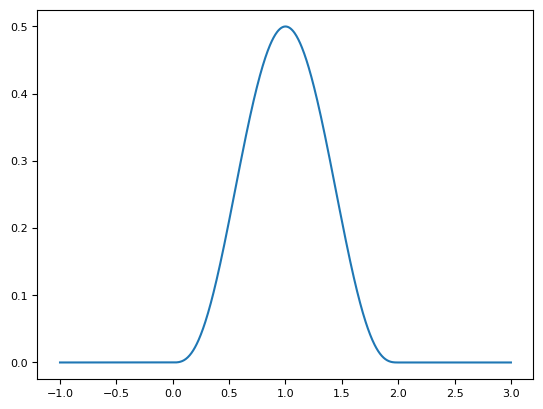

In [252]:
x = np.linspace(-1,3, 1000)
plt.plot(x, Thomas_Fermi_1d(x, 1, 1, 1))
plt.show()

## Import Data

In [ ]:
# import data
img_dir = '//DyLabNAS/Data/'
SequenceName = "Evaporative_Cooling" + "/"
folderPath = img_dir + SequenceName + '2023/04/24'# get_date()


shotNum = "0009"
filePath = folderPath + "/" + shotNum + "/*.h5"
filePath = folderPath + "/" + shotNum + "/2023-04-24_0009_Evaporative_Cooling_*0.h5"

# # load the data from HDF5 files
# dataSetDict = {
#     dskey[groupList[i]]: read_hdf5_file(filePath, groupList[i])
#     for i in [0] # range(len(groupList))
# }

# selecte the data for centain camera
dataSet = read_hdf5_file(filePath, "images/MOT_3D_Camera/in_situ_absorption")
# flip the x and y axis
dataSet = swap_xy(dataSet)

# get the scan axis name of the shot
scanAxis = get_scanAxis(dataSet)

# rechunck the data for parallel computing
dataSet = auto_rechunk(dataSet)

# calculate the absorption imaging
dataSet = imageAnalyser.get_absorption_images(dataSet)

dataSet

OD = dataSet["OD"]

OD_np = OD.to_numpy()

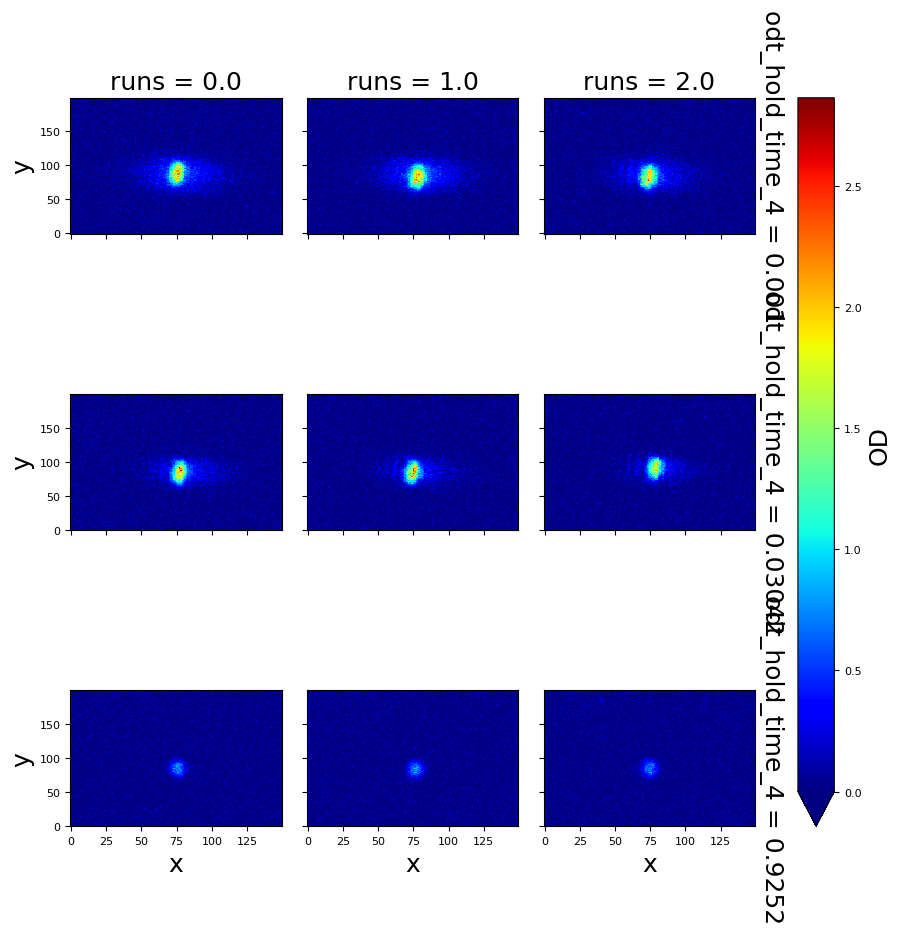

In [211]:
imageAnalyser.center = (960, 890)
imageAnalyser.span = (150, 200)
imageAnalyser.fraction = (0.1, 0.1)

dataSet_cropOD = imageAnalyser.crop_image(dataSet.OD)
dataSet_cropOD = imageAnalyser.substract_offset(dataSet_cropOD).load()
cropOD = dataSet_cropOD.to_numpy()
dataSet_cropOD.plot.pcolormesh(cmap='jet', vmin=0, col=scanAxis[1], row=scanAxis[0])
plt.show()

## Guess center

ToDo: Crop from center guess

In [214]:
# from opencv import moments
shape = np.shape(cropOD)
sigma = 0.4
blurred = gaussian_filter(cropOD, sigma=sigma)

thresh = np.zeros(shape)
for i in range(0,shape[0]):
    for j in range(0, shape[1]):
        thresh[i,j] = np.where(blurred[i,j] < np.max(blurred[i,j])*0.5,0,1)

# thresh = gaussian_filter(thresh, sigma=0.1)
# thresh = np.where(thresh<0.1,0,1)

#M = moments(thresh)

In [215]:
center = calc_cen_bulk(thresh)
print(center)

[[[75.69178082 88.5       ]
  [77.85648148 83.31944444]
  [74.20467836 83.28654971]]

 [[77.33333333 84.52136752]
  [74.9516129  84.98387097]
  [78.32758621 90.42528736]]

 [[76.02054795 84.00684932]
  [76.22058824 83.63970588]
  [75.00787402 84.74015748]]]


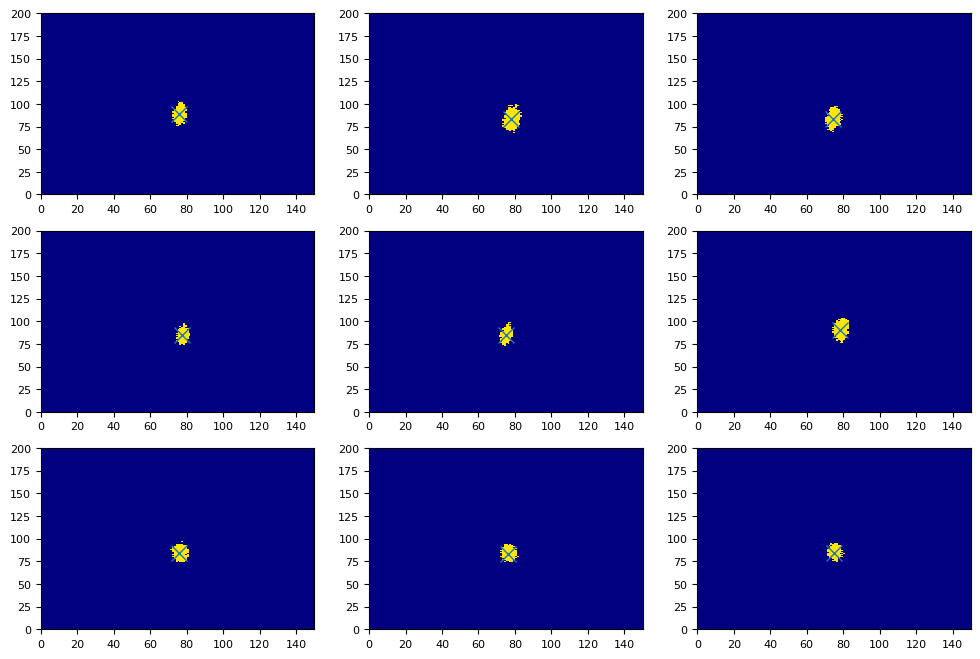

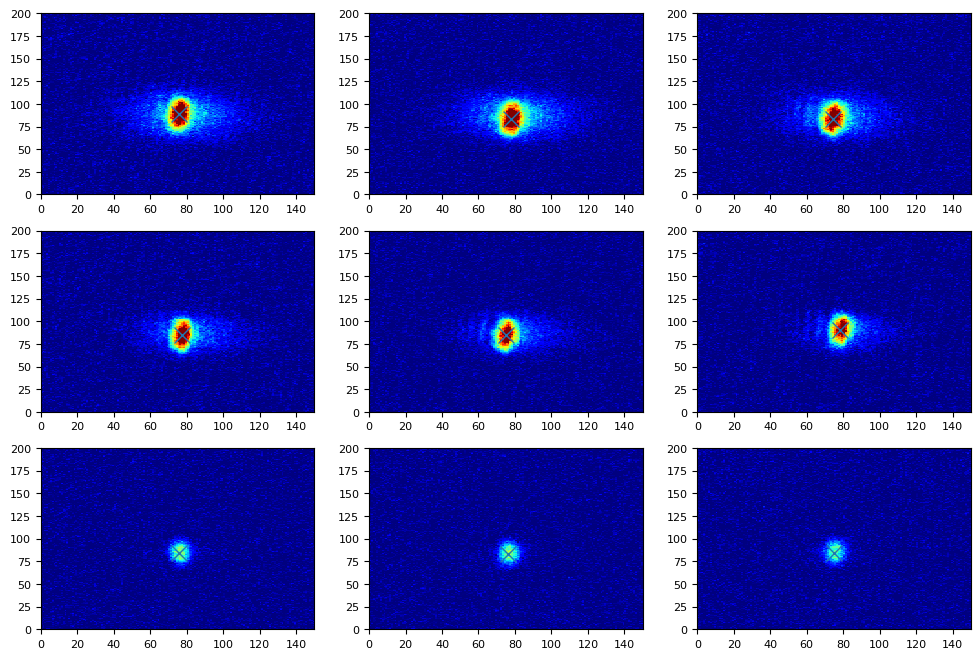

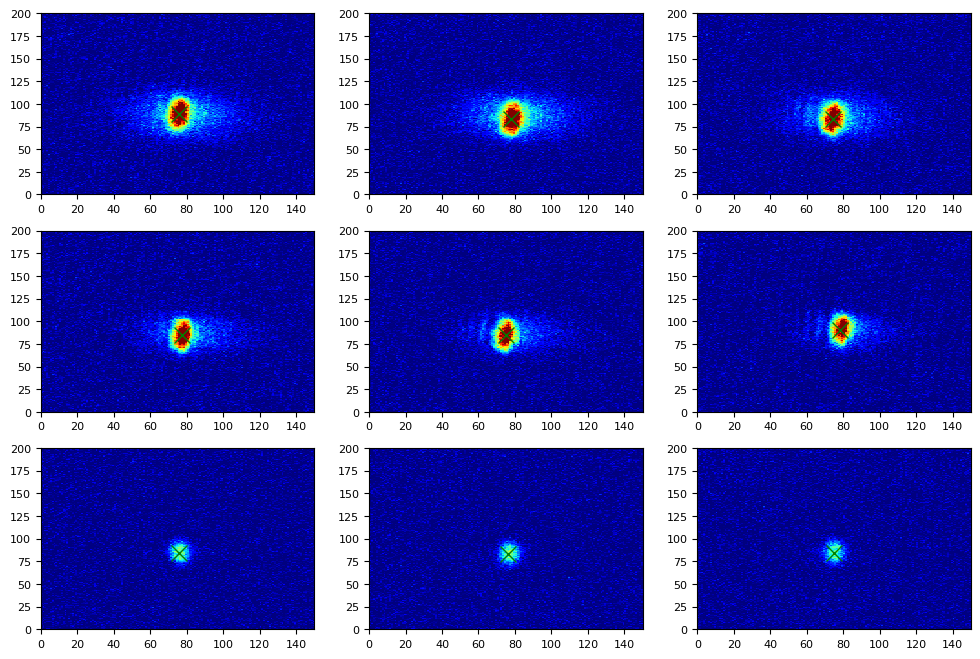

In [216]:
fsize = (12,8)

nr_plots = 3

fig, ax = plt.subplots(nr_plots,nr_plots,figsize=fsize)

for i in range(0,nr_plots):
    for j in range(0,nr_plots):
        # ax[i][j].pcolormesh(blurred[i][j], cmap='jet', vmin=0, vmax=1.5, alpha=1)
        ax[i][j].pcolormesh(thresh[i][j], cmap='jet', vmin=0, vmax=1.5, alpha=1)
        #ax[i][j].pcolormesh(cropOD[i][j], cmap='hot', vmin=0, vmax=1, alpha=1)
        ax[i][j].plot(center[i,j,0],center[i,j,1], marker='x', markersize=12)
plt.show()

fig, ax = plt.subplots(nr_plots,nr_plots,figsize=fsize)
for i in range(0,nr_plots):
    for j in range(0,nr_plots):
        ax[i][j].pcolormesh(blurred[i][j], cmap='jet', vmin=0, vmax=1.5, alpha=1)
        #ax[i][j].pcolormesh(thresh[i][j], cmap='jet', vmin=0, vmax=1.5, alpha=1)
        #ax[i][j].pcolormesh(cropOD[i][j], cmap='hot', vmin=0, vmax=1, alpha=1)
        ax[i][j].plot(center[i,j,0],center[i,j,1], marker='x', markersize=12)
plt.show()

fig, ax = plt.subplots(nr_plots,nr_plots,figsize=fsize)
for i in range(0,nr_plots):
    for j in range(0,nr_plots):
        ax[i][j].pcolormesh(cropOD[i][j], cmap='jet', vmin=0, vmax=1.5)
        #ax[i][j].plot(max[i,j,1],max[i,j,0], marker='x', markersize=12)
        ax[i][j].plot(center[i,j,0],center[i,j,1], marker='x', color='g', markersize=12)
plt.show()

## Guess width

In [217]:
def guess_BEC_width(thresh, center):
    """
    returns width of thresholded area along both axis through the center with shape of thresh and [X_width, Y_width] for each image
    """
    shape = np.shape(thresh)
    BEC_width_guess = np.zeros((shape[0], shape[1], 2))

    for i in range(0, shape[0]):
        for j in range(0, shape[1]):
            BEC_width_guess[i, j, 0] = np.sum(thresh[i, j, round(center[i,j,1]), :])
            BEC_width_guess[i, j, 1] = np.sum(thresh[i, j, :, round(center[i,j,0])])

    return BEC_width_guess

BEC_width_guess = guess_BEC_width(thresh, center)

print(BEC_width_guess)

[[[ 8. 25.]
  [ 8. 26.]
  [ 9. 26.]]

 [[ 7. 19.]
  [ 7. 21.]
  [ 8. 26.]]

 [[ 8. 20.]
  [ 9. 18.]
  [ 8. 20.]]]


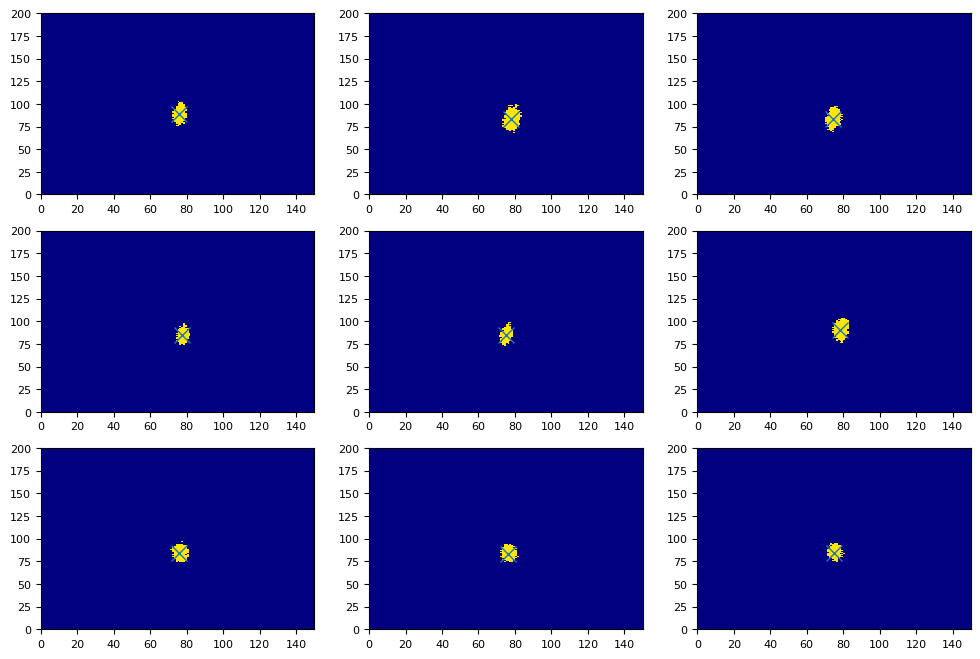

In [199]:
# %matplotlib notebook
fig, ax = plt.subplots(nr_plots,nr_plots,figsize=fsize)

for i in range(0,nr_plots):
    for j in range(0,nr_plots):
        # ax[i][j].pcolormesh(blurred[i][j], cmap='jet', vmin=0, vmax=1.5, alpha=1)
        ax[i][j].pcolormesh(thresh[i][j], cmap='jet', vmin=0, vmax=1.5, alpha=1)
        #ax[i][j].pcolormesh(cropOD[i][j], cmap='hot', vmin=0, vmax=1, alpha=1)
        ax[i][j].plot(center[i,j,0],center[i,j,1], marker='x', markersize=12)
plt.show()


## Mask array

In [200]:
masked = np.where(thresh==0, cropOD, np.nan)
np.shape(masked)

(3, 3, 200, 150)

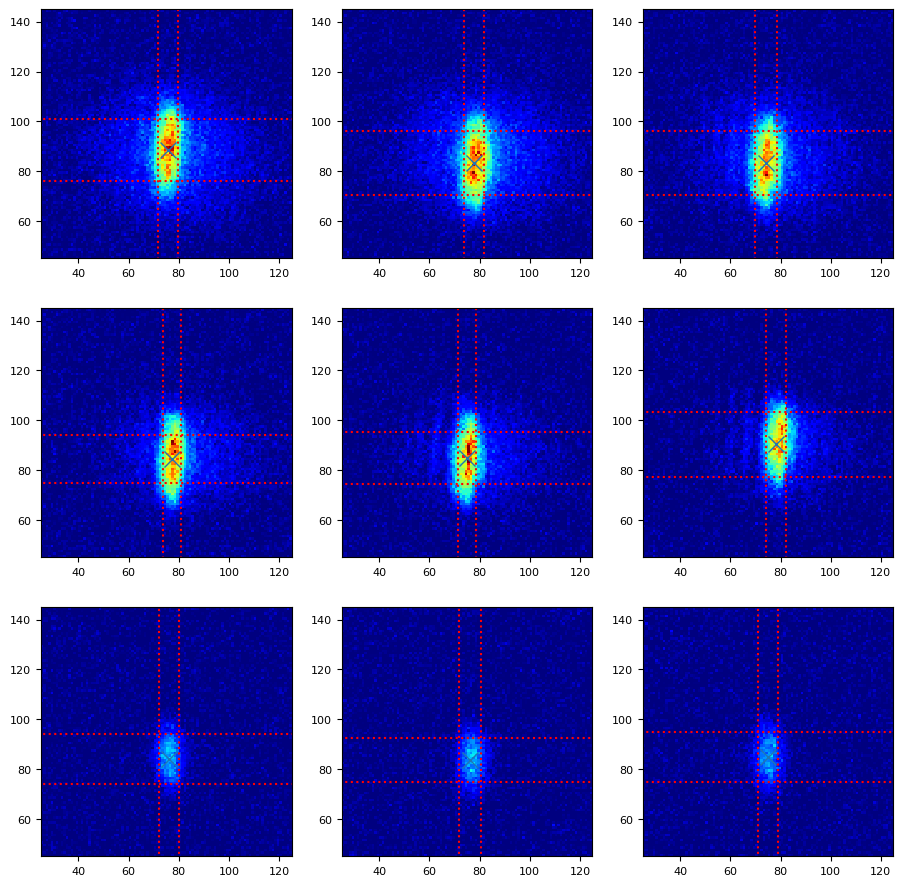

In [279]:
fig, ax = plt.subplots(nr_plots,nr_plots,figsize=(11,11))

cut_factor = 1

for i in range(0,nr_plots):
    for j in range(0,nr_plots):
        #print(np.nanmax(masked[i,j]))
        # ax[i][j].pcolormesh(blurred[i][j], cmap='jet', vmin=0, vmax=1.5, alpha=1)
        #ax[i][j].pcolormesh(masked[i][j], cmap='jet', vmin=0, vmax=0.5, alpha=1)
        ax[i][j].pcolormesh(cropOD[i][j], cmap='jet', vmin=0, vmax=2.5, alpha=1)
        #ax[i][j].pcolormesh(thresh[i][j], cmap='jet', vmin=0, vmax=1.5, alpha=1)
        #ax[i][j].pcolormesh(cropOD[i][j], cmap='hot', vmin=0, vmax=1, alpha=1)
        ax[i][j].plot(center[i,j,0],center[i,j,1], marker='x', markersize=12)
        alpha=1
        ax[i][j].hlines(center[i,j,1] - cut_factor * BEC_width_guess[i,j,1]/2, 0, 150, color='r',alpha=alpha,linestyles='dotted')
        ax[i][j].hlines(center[i,j,1] + cut_factor * BEC_width_guess[i,j,1]/2, 0, 150, color='r',alpha=alpha,linestyles='dotted')

        ax[i][j].vlines(center[i,j,0] - cut_factor * BEC_width_guess[i,j,0]/2, 0, 200, color='r',alpha=alpha,linestyles='dotted')
        ax[i][j].vlines(center[i,j,0] + cut_factor * BEC_width_guess[i,j,0]/2, 0, 200, color='r',alpha=alpha,linestyles='dotted')

        ax[i][j].set_xlim(25,125)
        ax[i][j].set_ylim(45,145)
plt.show()

## Cut out region of interest for thermal fitting guess

In [243]:
shape = np.shape(masked)

X_guess = np.zeros((shape[0], shape[1], shape[3]))
Y_guess = np.zeros((shape[0], shape[1], shape[2]))
for i in range(0, shape[0]):
    for j in range(0, shape[1]):
        X_guess[i,j] = np.sum(masked[i,j,round(center[i,j,1] - cut_factor * BEC_width_guess[i,j,1]/2) : round(center[i,j,1] + cut_factor * BEC_width_guess[i,j,1]/2) , :], 0) / len(masked[i,j,round(center[i,j,1] - cut_factor * BEC_width_guess[i,j,1]/2) : round(center[i,j,1] + cut_factor * BEC_width_guess[i,j,1]/2),0])

        Y_guess[i,j] = np.sum(masked[i,j, :, round(center[i,j,0] - cut_factor * BEC_width_guess[i,j,0]/2) : round(center[i,j,0] + cut_factor * BEC_width_guess[i,j,0]/2)], 1) / len(masked[i,j,0,round(center[i,j,0] - cut_factor * BEC_width_guess[i,j,0]/2) : round(center[i,j,0] + cut_factor * BEC_width_guess[i,j,0]/2)])


#print(X_guess)

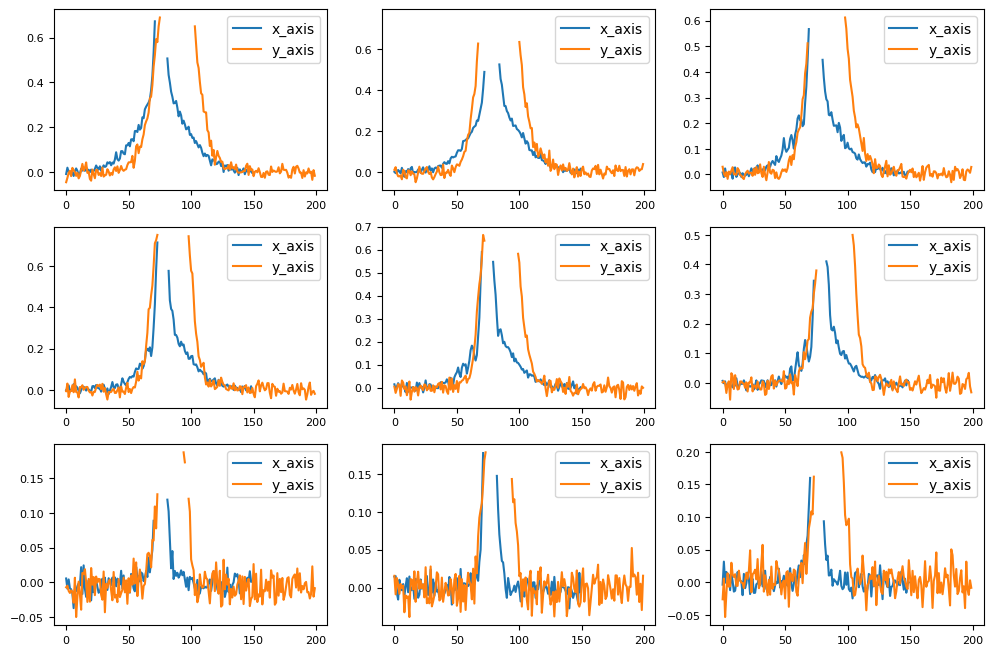

In [244]:
fig, ax = plt.subplots(nr_plots,nr_plots,figsize=fsize)

for i in range(0, shape[0]):
    for j in range(0, shape[1]):
        ax[i,j].plot(X_guess[i,j], label = 'x_axis')
        ax[i,j].plot(Y_guess[i,j], label = 'y_axis')
        ax[i,j].legend(fontsize=10)
plt.show()


## Fitting 1D gaussian

In [245]:
#[nr images x, nr images y, X / Y, center / sigma]
x = np.linspace(0,149,150)
y = np.linspace(0,199, 200)

popt = np.zeros((shape[0], shape[1], 2, 3))

p0 = np.ones((shape[0], shape[1], 2, 3))

p0[:, :, :, 0] = center
p0[:, :, :, 1] = BEC_width_guess / 2.355
p0[:, :, :, 2] = 0.1


for i in range(0, shape[0]):
    for j in range(0, shape[1]):
        popt[i,j, 0], pcov = curve_fit(gaussian, x, X_guess[i,j] , p0[i, j, 0], nan_policy='omit')
        popt[i,j, 1], pcov = curve_fit(gaussian, y, Y_guess[i,j] , p0[i, j, 1], nan_policy='omit')

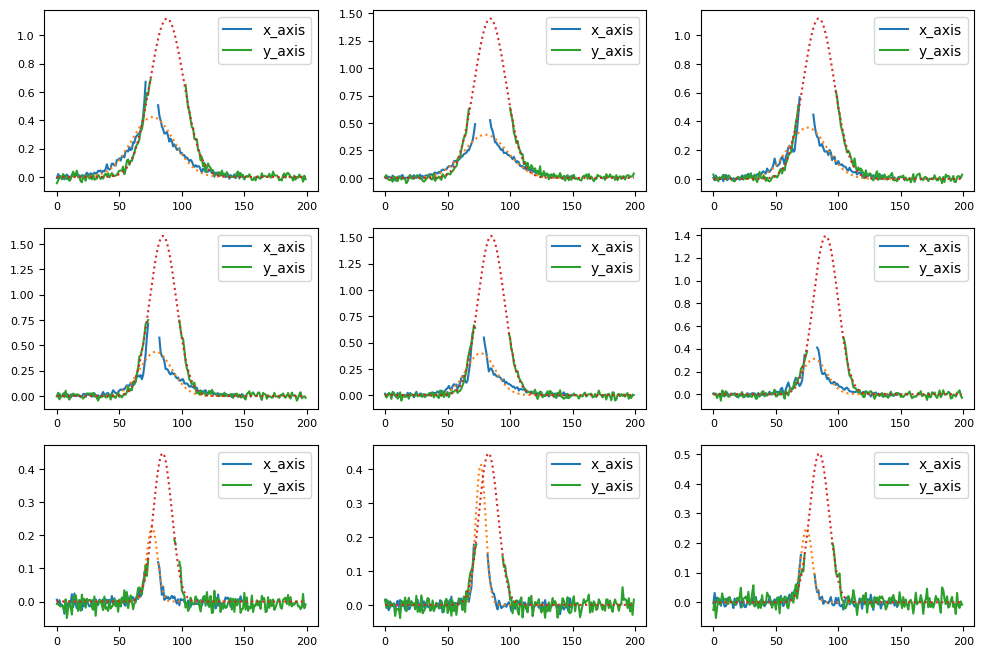

In [246]:
fig, ax = plt.subplots(nr_plots,nr_plots,figsize=fsize)
for i in range(0, shape[0]):
    for j in range(0, shape[1]):
        ax[i,j].plot(x, X_guess[i,j], label = 'x_axis')
        ax[i,j].plot(x, gaussian(x, *popt[i,j,0]), linestyle='dotted')

        ax[i,j].plot(y, Y_guess[i,j], label = 'y_axis')
        ax[i,j].plot(y, gaussian(y, *popt[i,j,1]), linestyle='dotted')
        ax[i,j].legend(fontsize=10)
        ax[i,j].set_facecolor('#FFFFFF')
plt.show()

## Try with not masked array


In [209]:
shape = np.shape(masked)

X_guess_og = np.zeros((shape[0], shape[1], shape[3]))
Y_guess_og = np.zeros((shape[0], shape[1], shape[2]))

for i in range(0, shape[0]):
    for j in range(0, shape[1]):
        X_guess_og[i,j] = np.sum(cropOD[i,j,round(center[i,j,1] - BEC_width_guess[i,j,1]/2) : round(center[i,j,1] + BEC_width_guess[i,j,1]/2) , :], 0) / len(masked[i,j,round(center[i,j,1] - BEC_width_guess[i,j,1]/2) : round(center[i,j,1] + BEC_width_guess[i,j,1]/2),0])

        Y_guess_og[i,j] = np.sum(cropOD[i,j, :, round(center[i,j,0] - BEC_width_guess[i,j,0]/2) : round(center[i,j,0] + BEC_width_guess[i,j,0]/2)], 1) / len(masked[i,j,0,round(center[i,j,0] - BEC_width_guess[i,j,0]/2) : round(center[i,j,0] + BEC_width_guess[i,j,0]/2)])

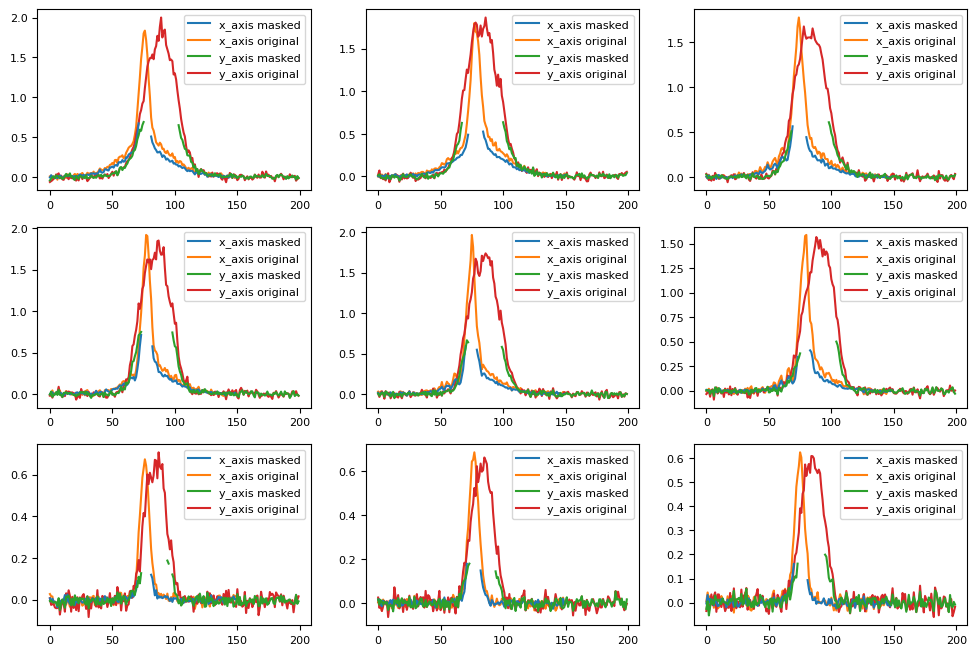

In [265]:
fig, ax = plt.subplots(nr_plots,nr_plots,figsize=fsize)

for i in range(0, shape[0]):
    for j in range(0, shape[1]):
        ax[i,j].plot(x, X_guess[i,j], label = 'x_axis masked',zorder=5)
        ax[i,j].plot(x, X_guess_og[i,j], label = 'x_axis original')
#         ax[i,j].legend(fontsize=10)
# plt.show()
#
# fig, ax = plt.subplots(nr_plots,nr_plots,figsize=fsize)
#
# for i in range(0, shape[0]):
#     for j in range(0, shape[1]):
        ax[i,j].plot(y, Y_guess[i,j], label = 'y_axis masked',zorder=5)
        ax[i,j].plot(y, Y_guess_og[i,j], label = 'y_axis original')
        ax[i,j].legend(fontsize=8)
plt.show()

## Bimodal 1d Fit

In [293]:
#[nr images x, nr images y, X / Y, center / sigma]
x = np.linspace(0,149,150)
y = np.linspace(0,199, 200)

popt = np.zeros((shape[0], shape[1], 6))

p0 = np.ones((shape[0], shape[1], 6))

max = np.zeros((shape[0], shape[1]))

for i in range(0, shape[0]):
    max[i] = np.ndarray.max(X_guess_og[i],axis=1)


p0[:, :, 0] = center[:, :, 0]  # center BEC
p0[:, :, 1] = center[:, :, 0]   # center th
p0[:, :, 2] = 0.7 * max          # amp BEC
p0[:, :, 3] = 0.3 * max         # amp th
p0[:, :, 4] = BEC_width_guess[:, :, 0]   # sigma BEC
p0[:, :, 5] = BEC_width_guess[:, :, 0] * 3          # sigma th

start = time.time()
for i in range(0, shape[0]):
    for j in range(0, shape[1]):
        popt[i,j], pcov = curve_fit(density_1d, x, X_guess_og[i,j] , p0[i, j], nan_policy='omit')
stop = time.time()

print(f'fitting time: {(stop-start)*1e3} ms')
        #popt[i,j, 1], pcov = curve_fit(density_1d, y, Y_guess_og[i,j] , p0[i, j, 1], nan_policy='omit')

fitting time: 189.01324272155762 ms


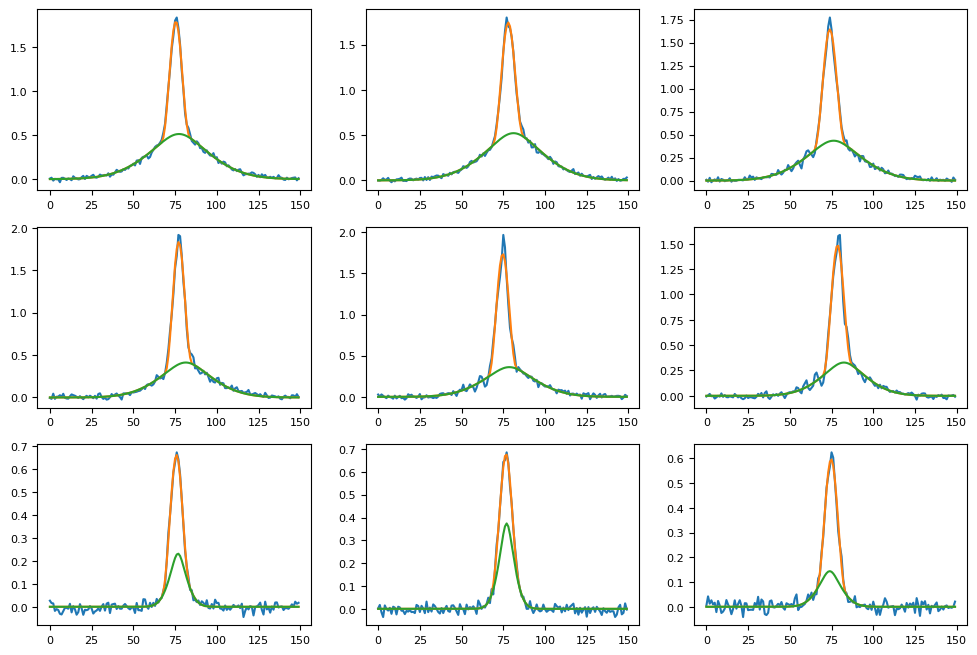

In [294]:
fig, ax = plt.subplots(nr_plots,nr_plots,figsize=fsize)
for i in range(0, shape[0]):
    for j in range(0, shape[1]):
        lab = f"A$_{{BEC}}$ = {popt[i,j,0]:.1f} \n A$_{{th}}$ = {popt[i,j,1]:.1f} "
        ax[i,j].plot(x, X_guess_og[i,j])
        ax[i,j].plot(x, density_1d(x, *popt[i,j]), label = lab)
        ax[i,j].plot(x, thermal(x, popt[i,j,1], popt[i,j, 3], popt[i,j, 5]))


        #ax[i,j].legend(fontsize=10)
        ax[i,j].set_facecolor('#FFFFFF')
plt.show()

In [295]:
for i in range(0,3):
    for j in range(0,3):
        print(p0[i,j])
        print(popt[i,j])
        print("")

[75.69178082 75.69178082  1.28576093  0.5510404   8.         24.        ]
[75.41570333 77.33388115  2.56706786  0.32435386  9.02534473 21.78913789]

[77.85648148 77.85648148  1.26012635  0.54005415  8.         24.        ]
[77.87651631 81.11230043  2.46976259  0.33019881  9.77967464 21.30093181]

[74.20467836 74.20467836  1.24055688  0.53166723  9.         27.        ]
[73.89357632 76.27664646  2.4312179   0.27440553  9.98643754 20.45775545]

[77.33333333 77.33333333  1.34319384  0.5756545   7.         21.        ]
[77.11393592 81.40236184  2.88921236  0.26104054  8.62447632 18.73504104]

[74.9516129  74.9516129   1.37694159  0.59011782  7.         21.        ]
[74.59729659 78.58410424  2.78343705  0.22861603  9.03257479 18.55393163]

[78.32758621 78.32758621  1.11153483  0.47637207  8.         24.        ]
[78.50292483 82.40258606  2.35517079  0.20782915  9.17053985 15.99073945]

[76.02054795 76.02054795  0.47105793  0.20188197  8.         24.        ]
[75.51767384 76.75506578  0.8744